#### Prediction with Machine Learning for Economists: Assignment 1

Tatyana Yakushina

In [42]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess

warnings.filterwarnings("ignore")


In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/cps-earnings/clean/"
data_out = dirname + "da_case_studies/ch09-gender-age-earnings/"
output = dirname + "da_case_studies/ch09-gender-age-earnings/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [3]:
# Import the prewritten helper functions
from py_helper_functions import *


In [34]:
#data_all = pd.read_csv(data_in + "morg-2014-emp.csv")
data_all = pd.read_csv("https://osf.io/download/4ay9x/")
data_all.head()

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
0,3,2600310997690,January,AL,3151.6801,1692.00,40,43,1,NaN,...,0,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work
1,5,75680310997590,January,AL,3457.1138,450.00,40,41,2,NaN,...,2,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent
2,6,75680310997590,January,AL,3936.9110,1090.00,60,41,2,NaN,...,2,6,"Native, Born In US",63,Motor vehicles and motor vehicle equipment man...,8140,"Private, For Profit",No,No,Employed-At Work
3,10,179140131100930,January,AL,3288.3640,769.23,40,40,1,NaN,...,2,4,"Native, Born In US",63,"**Publishing, except newspapers and software (...",8255,"Private, For Profit",Yes,NaN,Employed-At Work
4,11,179140131100930,January,AL,3422.8500,826.92,40,43,1,NaN,...,2,4,"Native, Born In US",63,"Banking and related activities (521, 52211,52219)",5940,"Private, For Profit",No,No,Employed-At Work


In [67]:
# checking the number of observations
data_all[data_all['occ2012']==2320].shape[0]

# choose occupation of secondary school teachers
data_occ = data_all[data_all['occ2012']==2320]

In [105]:
# Preparing data: creating and editing columns
data_occ["w"] = data_occ["earnwke"] / data_occ["uhours"]
data_occ["lnw"] = np.log(data_occ["w"])

data_occ["female"] = (data_occ["sex"] == 2)
data_occ["female"].value_counts()

data_occ["agesq"] = np.power(data_occ["age"], 2)

data_occ["ed_BA"] = (data_occ["grade92"] == 43).astype(int)
data_occ["ed_MA"] = (data_occ["grade92"] == 44).astype(int)
data_occ["ed_Profess"] = (data_occ["grade92"] == 45).astype(int)
data_occ["ed_Phd"] = (data_occ["grade92"] == 46).astype(int)

data_occ["native_american"] = data_occ["prcitshp"].isin(["Native, Born Abroad Of US Parent(s)"]).astype(int)

In [106]:
# descriptive statistics
data_occ.loc[:, ["earnwke", "uhours", "w"]].describe()

,earnwke,uhours,w
count,1323.000000,1323.000000,1323.000000
mean,1082.366077,41.993197,26.297867
std,514.676519,9.616903,14.472356
min,36.920000,2.000000,2.400000
25%,769.000000,40.000000,18.014375
50%,1000.000000,40.000000,23.125000
75%,1314.140000,45.000000,31.250000
max,2884.610000,80.000000,288.461000


In [107]:
data_occ.loc[:, ["age"]].describe()

,age
count,1323.00000
mean,42.35223
std,11.28418
min,17.00000
25%,33.00000
50%,42.00000
75%,52.00000
max,64.00000


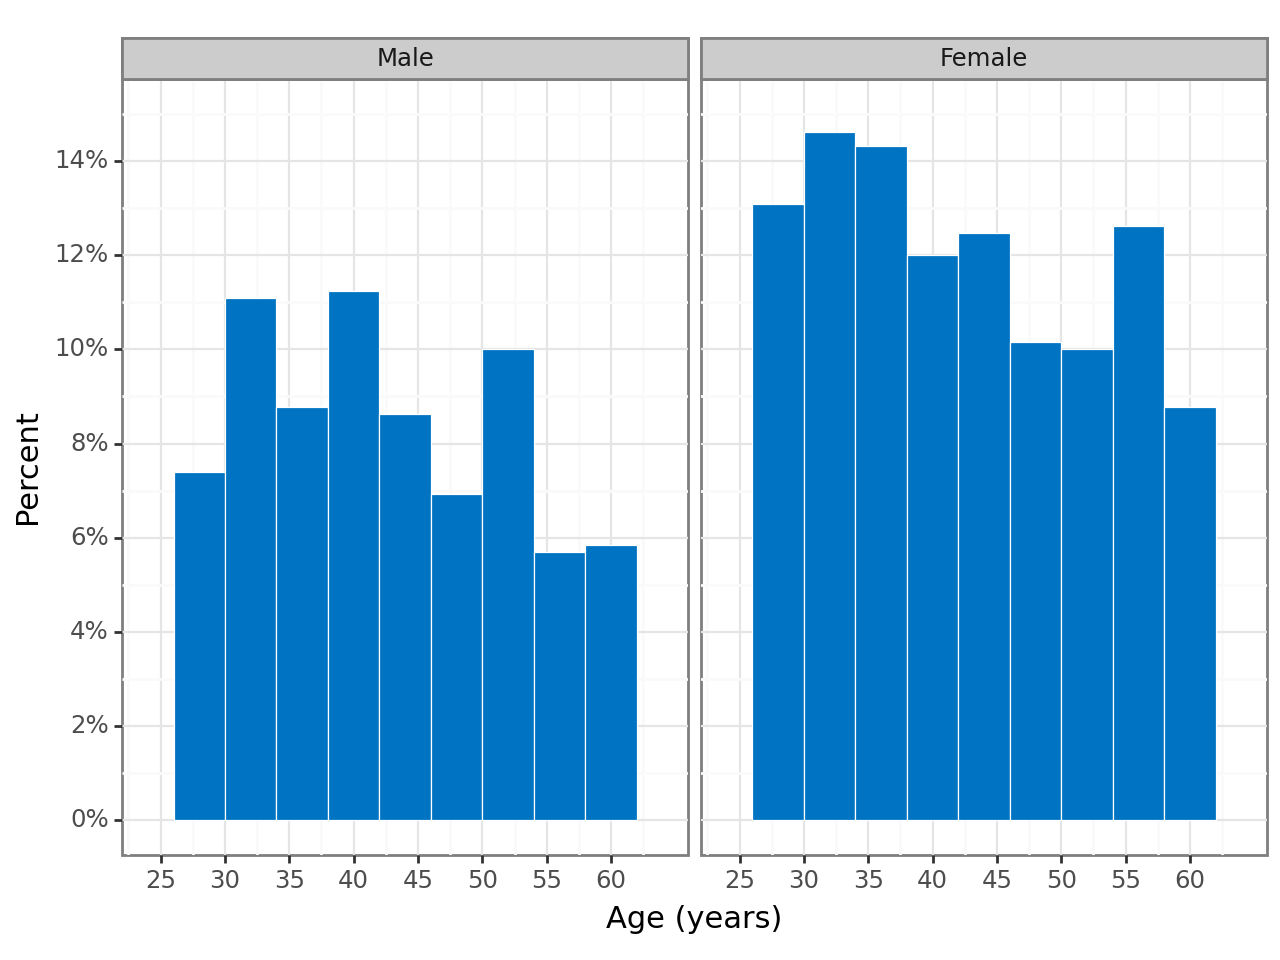

<Figure Size: (640 x 480)>

In [108]:
(
    ggplot(data_occ, aes(x="age", y="2*stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=4,
        color="white",
        fill="#0073C2FF",  # You can change the color as needed
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Age (years)", y="Percent")
    + facet_wrap("~female", labeller=as_labeller({"False": "Male", "True": "Female"}))
    + scale_x_continuous(
        limits=(24, 64),
        breaks=range(25, 65, 5),
    )
    + scale_y_continuous(
        limits=(0, 0.15), breaks=seq(0, 0.15, 0.02), labels=percent_format()
    )
    + theme_bw()
)

### Linear regressions

In [114]:
data_occ.columns

Index(['Unnamed: 0', 'hhid', 'intmonth', 'stfips', 'weight', 'earnwke',
       'uhours', 'grade92', 'race', 'ethnic', 'age', 'sex', 'marital',
       'ownchild', 'chldpres', 'prcitshp', 'state', 'ind02', 'occ2012',
       'class', 'unionmme', 'unioncov', 'lfsr94', 'w', 'lnw', 'female',
       'agesq', 'ed_BA', 'ed_MA', 'ed_Profess', 'ed_Phd', 'Native American',
       'native_american'],
      dtype='object')

In [116]:
reg1 = smf.ols(formula="lnw~female", data=data_occ).fit(cov_type="HC1")
# reg1.summary()

reg2 = smf.ols(formula="lnw~female + age", data=data_occ).fit(cov_type="HC1")
# reg2.summary()

reg3 = smf.ols(formula="lnw~female + age + ed_BA + ed_MA + ed_Profess + ed_Phd", data=data_occ).fit(cov_type="HC1")

reg4 = smf.ols(formula="lnw~female + age + ed_BA + ed_MA + ed_Profess + ed_Phd + native_american", data=data_occ).fit(cov_type="HC1")
# reg4.summary()


In [117]:
stargazer = Stargazer([reg1, reg2, reg3, reg4])
stargazer.covariate_order(["female[T.True]", "age", "ed_BA", "ed_MA", "ed_Profess", "ed_Phd", "native_american", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant", "female[T.True]": "female", "lnw": "log(wage)"})
stargazer


In [ ]:
# The target variable (lnw)
y = data['lnw']

X1 = data[['female', 'age']]
X2 = data[['female', 'age', 'agesq']]
X3 = data[['female', 'age', 'agesq', 'female_ed_MA', 'female_ed_Phd']]
X4 = data[['female', 'age', 'agesq', 'female_ed_MA', 'female_ed_Phd', 'priv', 'gover']]

# RMSE in the full sample
def calculate_rmse(model, X, y):
    predictions = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    return rmse

# RMSE for each model 
rmse_reg1 = calculate_rmse(reg1, X1, y)
rmse_reg2 = calculate_rmse(reg2, X2, y)
rmse_reg3 = calculate_rmse(reg3, X3, y)
rmse_reg4 = calculate_rmse(reg4, X4, y)